### Double check the A2597 H$_2$ Mass given in Tremblay+16

The mass reported in Tremblay+16 relied on a measurement made by Philippe Salome in Paris, using GILDAS. I had double-checked it in CASA, finding a very similar result, and so we went with it. But Helen is now getting an emission integral that is a factor of ~2 larger, so let's triple check. 

In [1]:
import sys
import os
import glob

import numpy as np

from astropy.io import ascii
from astropy.table import QTable

from astropy.cosmology import FlatLambdaCDM

import astropy.units as u

import pyspeckit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

Make some units and cosmology

In [13]:
emission_integral_units_mJy = u.mJy * u.km / u.s
emission_integral_units_Jy = u.Jy * u.km / u.s

xco_unit = u.cm**(-2) * (u.K * u.km * u.s**(-1))**(-1)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
plt.rcParams.update({'font.size'     : 16,
                    'axes.labelsize' : 16,
                    'legend.fontsize': 16,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18,
                    'axes.linewidth' :  2  })
#style.use('ggplot')

### Read in the spectrum extracted using CASA

I extracted spectra using `casaviewer v4.6`, and saved them as simple ASCII files. The extracted spectra and their associated extraction regions are shown here:  

In [4]:
def makeSpectrum(file):
    
    # Read the raw ASCII spectrum into an Astropy TABLE object
    rawdata = ascii.read(file)
    
    # Give the columns meaningful names
    if 'col1' in rawdata.columns:
        rawdata.rename_column('col1','Velocity')
    if 'col2' in rawdata.columns:
        rawdata.rename_column('col2', 'FluxDensity')
        
    # Give the new columns proper units. 
    # We'll have to strip them later, because PySpecKit doesn't 
    # like "quantity" objects, but it's useful to have the functionality
    # anyway
    Velocity = rawdata['Velocity'] * (u.km / u.s)
    FluxDensityJy = rawdata['FluxDensity'] * u.Jy

    # Put the flux into mJy 
    FluxDensity = FluxDensityJy.to(u.mJy)
    
    # Manually write the errors. The RMS of the 10 km/s cube
    # is 0.30 mJy / 10 km/s channel. This is the error on the flux.
    # The velocity channel width is +/- 5 km/s, e.g. 10 km/s width. 
    VelErr = ((np.zeros(len(Velocity))) + 5.0) * (u.km / u.s)
    FluxErr = ((np.zeros(len(FluxDensity))) + 0.30) * u.mJy
    
    # Construct the main Astropy TABLE with Units
    spectrum = QTable([Velocity, FluxDensity, VelErr, FluxErr], names=("Velocity", "Flux Density", "Velocity Error", "Flux Error"))
    
    # Also constuct unit-free versions for passing to PySpecKit
    
    #flux = FluxDensity.value
    #vel = Velocity.value
    
    #rms = FluxErr.value
    #width = VelErr.value
    
    return spectrum

In [5]:
ascii_spectrum = 'data/entire_nebula_pbcorr.txt'

In [6]:
spectrum = makeSpectrum(ascii_spectrum)

This resturns an Astropy QTable, accessed like this: 

In [7]:
spectrum['Velocity']

<Quantity [ -5.00000000e+02, -4.90000000e+02, -4.80000000e+02,
            -4.70000000e+02, -4.60000000e+02, -4.50000000e+02,
            -4.40000000e+02, -4.30000000e+02, -4.20000000e+02,
            -4.10000000e+02, -4.00000000e+02, -3.90000000e+02,
            -3.80000000e+02, -3.70000000e+02, -3.60000000e+02,
            -3.50000000e+02, -3.40000000e+02, -3.30000000e+02,
            -3.20000000e+02, -3.10000000e+02, -3.00000000e+02,
            -2.90000000e+02, -2.80000000e+02, -2.70000000e+02,
            -2.60000000e+02, -2.50000000e+02, -2.40000000e+02,
            -2.30000000e+02, -2.20000000e+02, -2.10000000e+02,
            -2.00000000e+02, -1.90000000e+02, -1.80000000e+02,
            -1.70000000e+02, -1.60000000e+02, -1.50000000e+02,
            -1.40000000e+02, -1.30000000e+02, -1.20000000e+02,
            -1.10000000e+02, -1.00000000e+02, -9.00000000e+01,
            -8.00000000e+01, -7.00000000e+01, -6.00000000e+01,
            -5.00000000e+01, -4.00000000e+01, -3.000000

__Warning__: PySpecKit won't like Astropy units, so make sure to feed it unitless arrays, like this: 
```
spectrum['Velocity'].value
```

In [8]:
flux = spectrum['Flux Density'].value
error = spectrum['Flux Error'].value
velocity = spectrum['Velocity'].value
vel_error = spectrum['Velocity Error'].value

Now, instantiate a PySpecKit 'Spectrum' object. 

In [9]:
sp = pyspeckit.Spectrum(data=flux,
                        error=error,
                        xarr=velocity,
                        xarrkwargs={'unit':'km/s'},
                        unit='mJy')

The blank header warning is fine. 

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,101 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,101 [pyspeckit.spectrum.interactive]


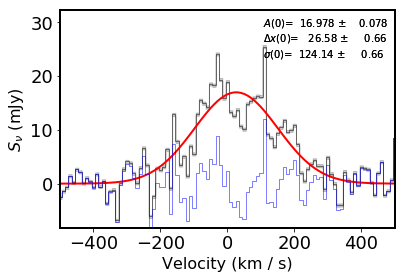

In [10]:
sp.specfit(fittype='gaussian')

amplitude_guess = flux.max()
center_guess = 0
width_guess = 250

guesses = [amplitude_guess, center_guess, width_guess]
sp.specfit(fittype='gaussian', guesses=guesses)

sp.plotter(errstyle='fill')
sp.specfit.plot_fit(lw=2)
sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.0,label=False, color='blue')


The analytic integral of the Gaussian fit is: 

In [11]:
integral = sp.specfit.integral(analytic=True)
integral

5282.8676723253766

e.g., $S_{CO} \Delta V = 5.28$ Jy km s$^{-1}$

In [12]:
""" 
Simpler version of `PSF_GAUSSIAN` in IDL. 
:Authors: Pey Lian Lim (Python) 
:Organization: Space Telescope Science Institute 
:History: 
    * 2010/08/17 PLL converted from IDL to Python. 
"""

# External modules 
import numpy 
#----------- 

def GaussPsf2D(npix, fwhm, normalize=True): 
    """ 
    Parameters 
    ---------- 
    npix: int 
        Number of pixels for each dimension. 
        Just one number to make all sizes equal. 
    fwhm: float 
        FWHM (pixels) in each dimension. 
        Single number to make all the same. 
    normalize: bool, optional 
        Normalized so total PSF is 1. 
    Returns 
    ------- 
    psf: array_like 
        Gaussian point spread function. 
    """ 
    # Initialize PSF params 
    cntrd = (npix - 1.0) * 0.5 
    st_dev = 0.5 * fwhm / numpy.sqrt( 2.0 * numpy.log(2) ) 
    # Make PSF 
    i = range(npix) 
    psf = numpy.array( [numpy.exp(-(((cntrd-x)/st_dev)**2+((cntrd-y)/st_dev)**2)/2) for x in i for y in i] ) 
    psf = psf.reshape(npix, npix) 
    # Normalize 
    if normalize: psf /= psf.sum() 
    return psf 